## **Notebook to make predictions with reprocessed Henson data and EFLUX2**

By Christina Schenk and Garrett Roell

Tested on biodesign_3.7 kernel on jprime

### EFLUX2 predictions and evaluations
This notebook predicts fluxes for R. opacus cultures growing with phenol. The data was published in [Henson (2018)](https://www.sciencedirect.com/science/article/pii/S1096717618300910).

#### **Data Labels:**
                                                 
#### Henson:
* WT 0.5g/L Phenol 		(**WT-P**)
* PVHG6 0.5g/L  Phenol 	(**PVHG-P**)

### Method: 
<ol>
<li>Predict fluxes with EFLUX2</li>
<li>Compare predictions with 13CMFA: Scatter plots and flux maps</li>
<li>Load file with observed growth rates (Notebook E)</li>
<li>Compare growth rate predictions with growth rate observations</li>
</ol>


#### **Set up imports**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import cobra
import scipy.stats
#import cplex
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.image as mpimg
import matplotlib.cm as cm

from edd_utils import login, export_study, export_metadata

from sklearn.metrics import r2_score

output_dir = '../plots/'
source_dir = '../src'
sys.path.append(source_dir)
from ensemblemethods import *


from plot import *
from utils import *

#### **Load Genome Scale Model**

In [2]:
model = cobra.io.read_sbml_model("../models/Ropacus_annotated_curated.xml")

#### **Load Transcript Data**

In [3]:
# read transcripts
transcript_df = pd.read_csv('../data/transcripts/csv/henson_CPM_melted.csv')

# isolate wildtype phenol data and adapted strain wildtype data
transcript_df_wt = transcript_df[transcript_df['Line Name'].str.contains("WT-P")]
transcript_df_pvhg = transcript_df[transcript_df['Line Name'].str.contains("PVHG-P")]

#### **Run E-Flux2 for Each Wild Type Trial**

In [4]:
# create dictionary to hold eflux solutions
eflux_solutions_wt = {}

for trial in ['WT-P-R1', 'WT-P-R2','WT-P-R3']:

    # display trial name
    trial_number = trial.split('-R')[1]
    trial_name = f'phenol_eflux_wt_{trial_number}'
    print(trial_name)

    transcriptomics = transcript_df_wt[transcript_df_wt['Line Name'] == trial]

    # map the transcripts to genome scale reactions
    trans_data = construct_trans_df(transcriptomics, trial)

    # run eflux to get genome scale fluxes
    eflux2_sol = eflux2_pred(model, trans_data, trial, 'phenol', sub_uptake_rate=100)

    print(f"The phenol uptake rate is {eflux2_sol['EX_phenol_e']}")

    # add eflux solution to dictionary
    eflux_solutions_wt[trial_name] = eflux2_sol

phenol_eflux_wt_1
FBA status optimal
FBA solution 5.986636795265596


{'EX_ca2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_zn2_e': 1000.0,
 'EX_phenol_e': 1000}

EFlux2 status optimal
EFlux2 solution 4196013.386170872
The phenol uptake rate is -152.77629825040202
phenol_eflux_wt_2
FBA status optimal
FBA solution 5.997345026707274


{'EX_ca2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_zn2_e': 1000.0,
 'EX_phenol_e': 1000}

EFlux2 status optimal
EFlux2 solution 834310.9286037758
The phenol uptake rate is -91.10970847349628
phenol_eflux_wt_3
FBA status optimal
FBA solution 2.856015673482203


{'EX_ca2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_zn2_e': 1000.0,
 'EX_phenol_e': 1000}

EFlux2 status optimal
EFlux2 solution 134247.20091495424
The phenol uptake rate is -28.130255244954903


#### **Run E-Flux2 for Each Adapted Strain (PVHG) Trial**

In [5]:
# create dictionary to hold eflux solutions
eflux_solutions_pvhg = {}

# 'PVHG-P-R3' causes an 'unbounded' solution
for trial in ['PVHG-P-R1', 'PVHG-P-R2']:

    # display trial name
    trial_number = trial.split('-R')[1]
    trial_name = f'phenol_eflux_pvhg_{trial_number}'
    print(trial_name)

    transcriptomics = transcript_df_pvhg[transcript_df_pvhg['Line Name'] == trial]

    # map the transcripts to genome scale reactions
    trans_data = construct_trans_df(transcriptomics, trial)

    # run eflux to get genome scale fluxes
    eflux2_sol = eflux2_pred(model, trans_data, trial, 'phenol', sub_uptake_rate=100)

    print(f"The phenol uptake rate is {eflux2_sol['EX_phenol_e']}")

    # add eflux solution to dictionary
    eflux_solutions_pvhg[trial_name] = eflux2_sol

phenol_eflux_pvhg_1
FBA status optimal
FBA solution 2.5359789794218486


{'EX_ca2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_zn2_e': 1000.0,
 'EX_phenol_e': 1000}

EFlux2 status optimal
EFlux2 solution 96194.33252626046
The phenol uptake rate is -23.61865902285064
phenol_eflux_pvhg_2
FBA status optimal
FBA solution 8.715246692920259


{'EX_ca2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_zn2_e': 1000.0,
 'EX_phenol_e': 1000}

EFlux2 status optimal
EFlux2 solution 1519955.9207466354
The phenol uptake rate is -91.44941663413617


#### **Save Phenol WT E-Flux2 Genome Scale Fluxes**

In [6]:
# loop over solution dictionary. Convert the flux solutions, convert each to a dataframe and save as csv
for trial_name, flux_solution in eflux_solutions_wt.items():

    flux_df = eflux_solution_to_df(model, flux_solution)
    flux_df.to_csv(f'../data/genome_scale_fluxes/{trial_name}.csv', index=False)

    display(flux_df.head(5))

,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,0.0
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,0.0
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,0.0
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,0.0
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,0.0


,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,0.0
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,0.0
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,0.0
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,0.0
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,0.0


,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,0.0
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,0.0
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,0.0
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,0.0
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,0.0


#### **Save Phenol PVHG E-Flux2 Genome Scale Fluxes**

In [7]:
# loop over solution dictionary. Convert the flux solutions, convert each to a dataframe and save as csv
for trial_name, flux_solution in eflux_solutions_pvhg.items():

    flux_df = eflux_solution_to_df(model, flux_solution)
    flux_df.to_csv(f'../data/genome_scale_fluxes/{trial_name}.csv', index=False)

    display(flux_df.head(5))

,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,0.0
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,0.0
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,0.0
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,0.0
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,0.0


,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,0.0
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,0.0
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,0.0
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,0.0
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,0.0


#### **Get Average and Standard Deviation of WT Genome Scale Fluxes**

In [8]:
# can curate trials to use
relevant_trials = [
    'phenol_eflux_wt_1', 
    'phenol_eflux_wt_2', 
    'phenol_eflux_wt_3',
]

# define constants to use below
uptake_reaction = 'EX_phenol_e'
normalized_uptake_rate = -100

# get list of relevant flux vectors
flux_vectors = [eflux_solutions_wt[trial_name].fluxes for trial_name in relevant_trials]

# combine into a single dataframe and name columns
all_flux_vector_df = pd.concat(flux_vectors, axis=1)
all_flux_vector_df.columns = relevant_trials

# scale columns so that all have the same uptake rate
for trial in relevant_trials:
    # get the uptake rate for the trial
    current_uptake_rate = all_flux_vector_df[trial][uptake_reaction]
    
    # calculate the scale factor to get the ratio of the current uptake rate to the normalized uptake value
    scale_factor = normalized_uptake_rate / all_flux_vector_df[trial][uptake_reaction]

    # update the fluxes in the dataframe with scaled fluxes
    all_flux_vector_df[trial] = scale_factor * all_flux_vector_df[trial]

# calculate average and standard deviation of flux vectors
average_eflux_solution_wt = pd.DataFrame(all_flux_vector_df.mean(axis=1), columns=['fluxes'])
std_eflux_solution_wt =  pd.DataFrame(all_flux_vector_df.std(axis=1), columns=['stds'])

# save average flux vector
average_eflux_solution_wt.to_csv('../data/genome_scale_fluxes/phenol_eflux.csv')

display(average_eflux_solution_wt.head())
display(std_eflux_solution_wt.head())

,fluxes
12DGR140tipp,0.0
13PPDH,0.0
1P2CBXLCYCL,0.0
1P2CBXLR,0.0
23CTI1,0.0


,stds
12DGR140tipp,0.0
13PPDH,0.0
1P2CBXLCYCL,0.0
1P2CBXLR,0.0
23CTI1,0.0


#### **Get average and standard deviation of Adapted Strain Genome Scale Fluxes**

In [9]:
# can curate trials to use
relevant_trials = [
    'phenol_eflux_pvhg_1', 
    'phenol_eflux_pvhg_2', 
#     'phenol_eflux_pvhg_3',
]

# define constants to use below
uptake_reaction = 'EX_phenol_e'
normalized_uptake_rate = -100

# get list of relevant flux vectors
flux_vectors = [eflux_solutions_pvhg[trial_name].fluxes for trial_name in relevant_trials]

# combine into a single dataframe and name columns
all_flux_vector_df = pd.concat(flux_vectors, axis=1)
all_flux_vector_df.columns = relevant_trials

# scale columns so that all have the same uptake rate
for trial in relevant_trials:
    # get the uptake rate for the trial
    current_uptake_rate = all_flux_vector_df[trial][uptake_reaction]
    
    # calculate the scale factor to get the ratio of the current uptake rate to the normalized uptake value
    scale_factor = normalized_uptake_rate / all_flux_vector_df[trial][uptake_reaction]

    # update the fluxes in the dataframe with scaled fluxes
    all_flux_vector_df[trial] = scale_factor * all_flux_vector_df[trial]

# calculate average and standard deviation of flux vectors
average_eflux_solution_pvhg = pd.DataFrame(all_flux_vector_df.mean(axis=1), columns=['fluxes'])
std_eflux_solution_pvhg =  pd.DataFrame(all_flux_vector_df.std(axis=1), columns=['stds'])

display(average_eflux_solution_pvhg.head())
display(std_eflux_solution_pvhg.head())

,fluxes
12DGR140tipp,0.0
13PPDH,0.0
1P2CBXLCYCL,0.0
1P2CBXLR,0.0
23CTI1,0.0


,stds
12DGR140tipp,0.0
13PPDH,0.0
1P2CBXLCYCL,0.0
1P2CBXLR,0.0
23CTI1,0.0


#### **Load Phenol 13C MFA Data**

In [10]:
phenol_fluxes = pd.read_csv('../data/central_fluxes/phenol_13C.csv')

# # Remove rows that do not have a mapping to the GSM
phenol_fluxes.dropna(subset = ["Forward Reactions"], inplace=True)
print(f'There are {len(phenol_fluxes)} fluxes that can be compared between the MFA and E-Flux2')

phenol_fluxes.head()

There are 44 fluxes that can be compared between the MFA and E-Flux2


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Substrate Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",100.0000,100.0000,100.0000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-0.4793,-1.4219,0.9306
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.0000,-2.0000,-0.7683
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.0000,-2.0000,-0.7683
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.0000,-2.0000,-0.7683


#### **Map Phenol E-Flux2 fluxes to 13C MFA Reactions**

In [11]:
phenol_fluxes = add_pred_fluxes_to_13c_df(phenol_fluxes, average_eflux_solution_wt, std_eflux_solution_wt, 'phenol', 'E-Flux2', 'WT')
phenol_fluxes = add_pred_fluxes_to_13c_df(phenol_fluxes, average_eflux_solution_pvhg, std_eflux_solution_pvhg, 'phenol', 'E-Flux2', 'PVHG')
phenol_fluxes.head()

scale_factor fluxes    1.0
Name: EX_phenol_e, dtype: float64
scale_factor fluxes    1.0
Name: EX_phenol_e, dtype: float64


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,E-Flux2 WT Value,E-Flux2 WT std Value,E-Flux2 PVHG Value,E-Flux2 PVHG std Value
0,Substrate Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",100.0000,100.0000,100.0000,100.000000,0.000000,100.000000,1.421085e-14
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-0.4793,-1.4219,0.9306,-1.109053,0.503906,-1.632438,1.374937e-01
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.0000,-2.0000,-0.7683,-2.239575,3.136692,-8.076188,2.710223e+00
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.0000,-2.0000,-0.7683,-2.239575,3.136692,-8.076188,2.710223e+00
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.0000,-2.0000,-0.7683,-5.690380,4.528687,-13.155501,2.282413e+00


#### **Save Phenol E-Flux2 Central Flux Predictions**

In [12]:
phenol_fluxes.to_csv('../data/central_fluxes/phenol_eflux.csv', index=False)

#### **Plot WT Phenol E-Flux2 Fluxes vs 13C MFA Fluxes**

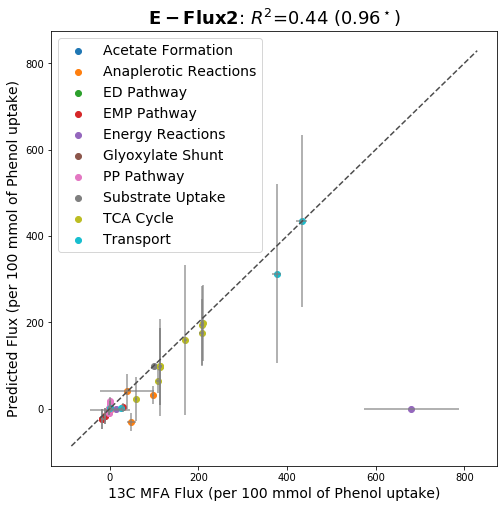

In [13]:
obs_vs_pred_scatter_plot_with_std(phenol_fluxes, substrate='phenol', method='E-Flux2', strain='WT', output_dir=output_dir)

#### **Plot PVHG Phenol E-Flux2 Fluxes vs 13C MFA Fluxes**

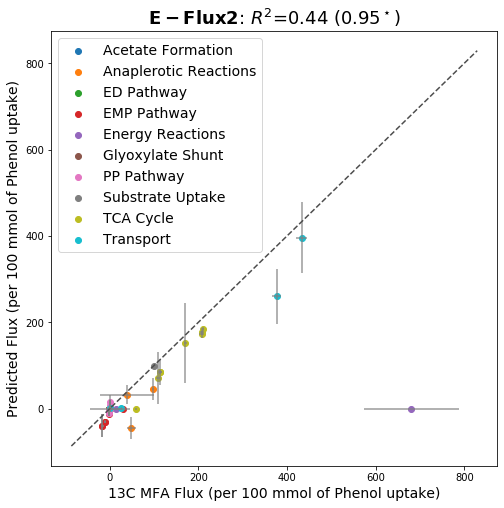

In [14]:
obs_vs_pred_scatter_plot_with_std(phenol_fluxes, substrate='phenol', method='E-Flux2', strain='PVHG', output_dir=output_dir)

#### **Display WT Phenol E-Flux2 Flux Map**

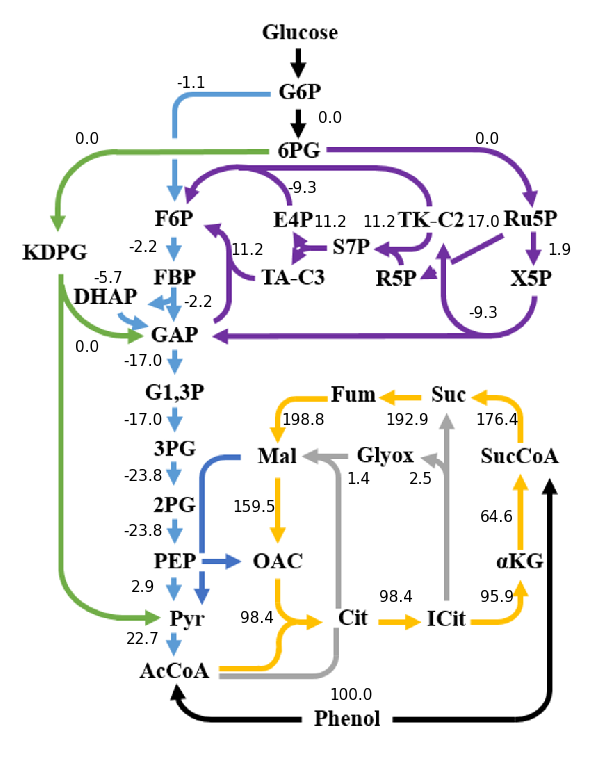

In [23]:
generate_flux_map(phenol_fluxes, 'E-Flux2 WT Value', substrate='phenol', method='E-Flux2', strain='WT', output_dir=output_dir)

#### **Display PVHG Phenol E-Flux2 Flux Map**

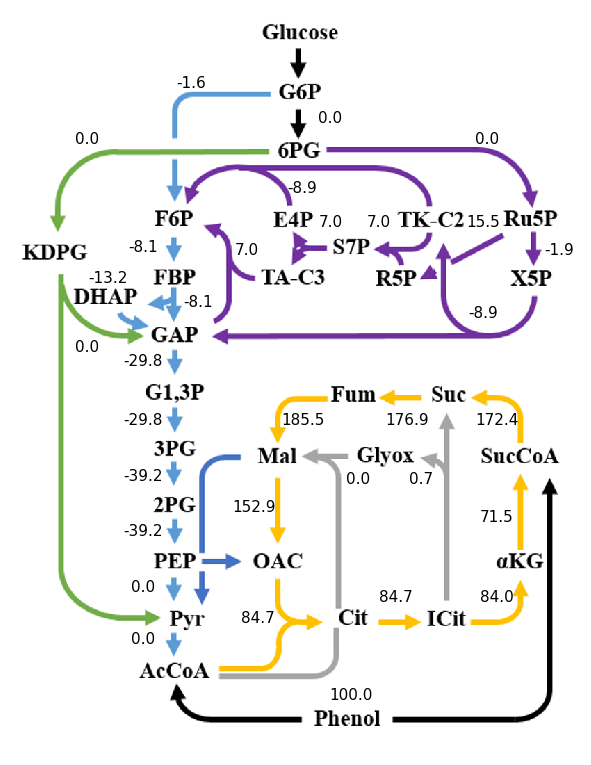

In [16]:
generate_flux_map(phenol_fluxes, 'E-Flux2 PVHG Value', substrate='phenol', method='E-Flux2', strain='PVHG', output_dir=output_dir)

#### **Load experimental growth parameters and E-Flux2 Glucose Data**

In [17]:
consumption_and_growth_data = pd.read_csv('../data/growth_rates/eflux2_growth_rates.csv', index_col=0)
consumption_and_growth_data

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev,E-Flux2 growth rate,E-Flux2 growth std
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279,NaN,NaN
PVHG-P,0.080331,0.040848,1.967485,0.002672,0.001757,0.021785,NaN,NaN
WT-G,0.260195,0.072789,3.582471,0.004749,0.004117,0.141675,0.426681,0.027616


#### **Calculate WT Phenol E-Flux2 Growth Rate**

In [18]:
# get experimental uptake rate from table
exp_uptake_rate = consumption_and_growth_data.loc['WT-P', 'substrate consumption rate']

# get average and standard deviation of growth rate from dataframes
average_growth_rate = average_eflux_solution_wt.loc['Growth_Phenol',:].values[0] 
std_growth_rate = std_eflux_solution_wt.loc['Growth_Phenol',:].values[0] 

# get average and standard deviation of uptake rate from dataframes
average_uptake_rate = average_eflux_solution_wt.loc['EX_phenol_e',:].values[0] 
std_uptake_rate = std_eflux_solution_wt.loc['EX_phenol_e',:].values[0] 

# normalize growth rate to experimental uptake rate
eflux_growth_rate_wt = -1 * exp_uptake_rate * (average_growth_rate / average_uptake_rate)
eflux_growth_rate_std_wt = -1 * exp_uptake_rate * (std_growth_rate / average_uptake_rate)

# Delete later
print(exp_uptake_rate)
print(average_growth_rate)
print('average uptake rate', average_uptake_rate)

1.3520722607432194
6.884647451098265
average uptake rate -100.0


#### **Calculate PVHG Phenol E-Flux2 Growth Rate**

In [19]:
# get experimental uptake rate from table
exp_uptake_rate = consumption_and_growth_data.loc['PVHG-P', 'substrate consumption rate']

# get average and standard deviation of growth rate from dataframes
average_growth_rate = average_eflux_solution_pvhg.loc['Growth_Phenol',:].values[0] 
std_growth_rate = std_eflux_solution_pvhg.loc['Growth_Phenol',:].values[0] 

# get average and standard deviation of uptake rate from dataframes
average_uptake_rate = average_eflux_solution_pvhg.loc['EX_phenol_e',:].values[0] 
std_uptake_rate = std_eflux_solution_pvhg.loc['EX_phenol_e',:].values[0] 

# normalize growth rate to experimental uptake rate
eflux_growth_rate_pvhg = -1 * exp_uptake_rate * (average_growth_rate / average_uptake_rate)
eflux_growth_rate_std_pvhg = -1 * exp_uptake_rate * (std_growth_rate / average_uptake_rate)

# Delete later
print(exp_uptake_rate)
print(average_growth_rate)
print('average uptake rate', average_uptake_rate)

1.96748494522118
10.133656342603055
average uptake rate -100.0


#### **Add Phenol E-Flux2 Data to E-Flux Growth Rate Data**

In [20]:
# get values added in notebook G
eflux_growth_rate_glucose = float(consumption_and_growth_data.loc['WT-G']['E-Flux2 growth rate'])
eflux_growth_rate_std_glucose = float(consumption_and_growth_data.loc['WT-G']['E-Flux2 growth std'])


consumption_and_growth_data['E-Flux2 growth rate'] = [
    eflux_growth_rate_wt, eflux_growth_rate_pvhg, eflux_growth_rate_glucose
]
consumption_and_growth_data['E-Flux2 growth std'] = [
    eflux_growth_rate_std_wt, eflux_growth_rate_std_pvhg, eflux_growth_rate_std_glucose
]
consumption_and_growth_data

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev,E-Flux2 growth rate,E-Flux2 growth std
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279,0.093085,0.042294
PVHG-P,0.080331,0.040848,1.967485,0.002672,0.001757,0.021785,0.199378,0.016793
WT-G,0.260195,0.072789,3.582471,0.004749,0.004117,0.141675,0.426681,0.027616


#### **Save E-Flux2 Growth Rates**

In [21]:
consumption_and_growth_data.to_csv('../data/growth_rates/eflux2_growth_rates.csv', index=True, header= True)

#### **Plot E-Flux2 Growth Rates**

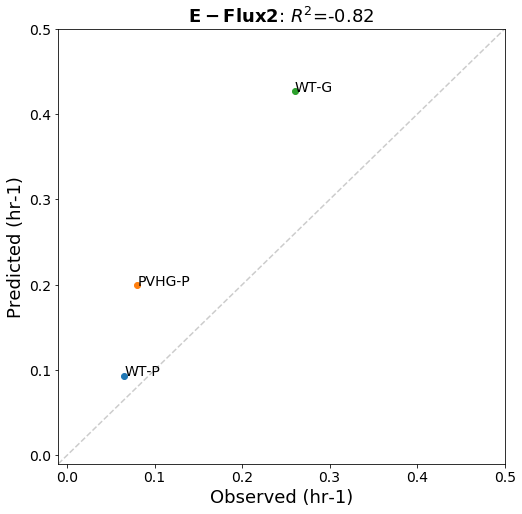

In [22]:
selectedlist = ['WT-P', 'PVHG-P', 'WT-G']
comparison_scatter_plot(
    consumption_and_growth_data.loc[selectedlist, 'growth rate'], 
    consumption_and_growth_data.loc[selectedlist, 'E-Flux2 growth rate'], 
    selectedlist, 
    'E-Flux2',
    [-0.01, 0.5], # x limits
    [-0.01, 0.5], # y limits
    output_dir=output_dir
)